In [1]:
import pandas as pd
import pickle
import numpy as np
import re
from sklearn import linear_model


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

import os
import warnings
warnings.filterwarnings('ignore') 


C:\Users\canbo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train=pd.read_csv('train.csv', parse_dates=['datetime'])
test=pd.read_csv('test.csv', parse_dates=['datetime'])

In [3]:
print(train.shape)
print(train.head())
print(train.dtypes)
print(test.shape)
print(test.columns)
print([i for i in train.columns if i not in test.columns]) 

(10886, 12)
             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity  

In [4]:
train = train.drop(['casual','registered'],axis=1)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [ ]:
sns.factorplot(x="hr",y="count",data=train,kind='bar',size=5,aspect=1.5)


In [5]:
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))

In [6]:
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 


In [7]:
for df in (train,test):
    
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hr'] = df['datetime'].dt.hour

    df['hr_categori'] = np.nan
    df.loc[(df.workingday == 1)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"
    df.loc[(df.workingday == 1)&(df.hr <= 19)&(df.hr >= 16), 'hr_categori'] = "rush"
    df.loc[(df.workingday == 1)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.workingday == 1)&(df.hr < 7)|(df.hr > 19), 'hr_categori'] = "night"

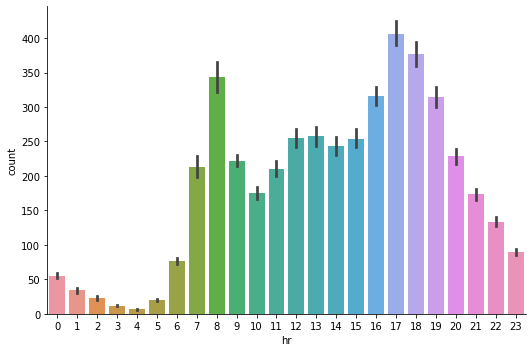

In [8]:
sns.factorplot(x="hr",y="count",data=train,kind='bar',size=5,aspect=1.5)


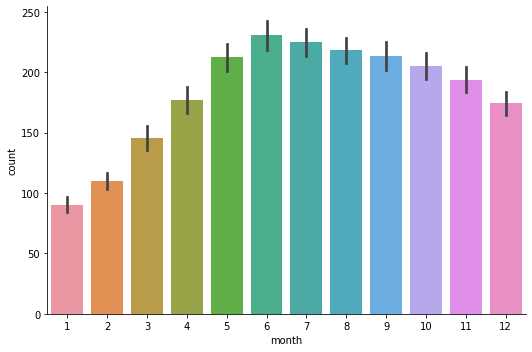

In [9]:
sns.factorplot(x="month",y="count",data=train,kind='bar',size=5,aspect=1.5)


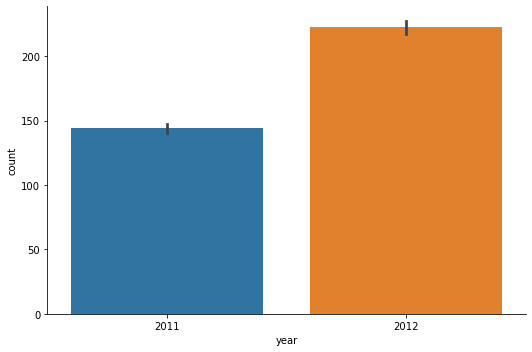

In [10]:
sns.factorplot(x="year",y="count",data=train,kind='bar',size=5,aspect=1.5)


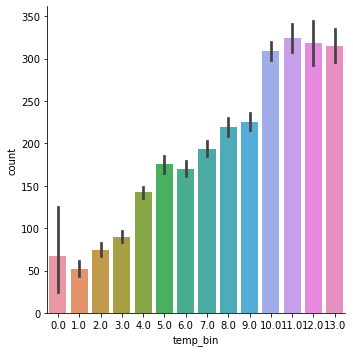

In [11]:
new_df=train.copy()

new_df['temp_bin']=np.floor(new_df['temp'])//3

sns.factorplot(x="temp_bin",y="count",data=new_df,kind='bar')

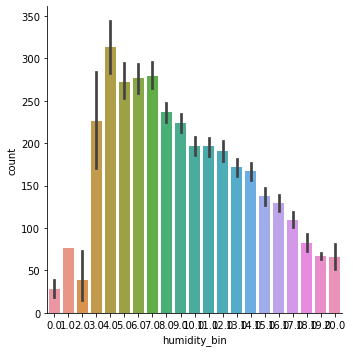

In [12]:
new_df=train.copy()
new_df['humidity_bin']=np.floor(new_df['humidity'])//5

sns.factorplot(x="humidity_bin",y="count",data=new_df,kind='bar')

In [13]:
for df in (train,test):
    df['humi_categori'] = np.nan
    df.loc[df.humidity < 15, 'humi_categori'] = 'low'
    df.loc[(df.humidity <= 85)&(df.humidity >= 15), 'humi_categori'] = 'normal'
    df.loc[(df.humidity >= 85), 'humi_categori'] = 'high'

In [14]:
train[train['windspeed']>=48]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hr,hr_categori,humi_categori
760,2011-02-15 01:00:00,1,0,1,1,12.30,12.12,42,51.9987,5,2011,2,15,1,night,normal
868,2011-02-19 15:00:00,1,0,0,1,18.04,21.97,16,50.0021,171,2011,2,19,15,NaN,normal
2755,2011-07-03 17:00:00,3,0,0,3,32.80,37.12,49,56.9969,358,2011,7,3,17,NaN,normal
2756,2011-07-03 18:00:00,3,0,0,3,32.80,37.12,49,56.9969,181,2011,7,3,18,NaN,normal


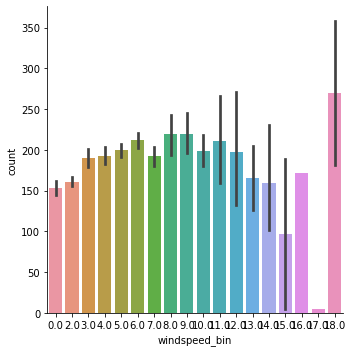

In [15]:
new_df=train.copy()

new_df['windspeed_bin']=np.floor(new_df['windspeed'])//3
sns.factorplot(x="windspeed_bin",y="count",data=new_df,kind='bar')

In [16]:
for df in (train,test):
    df['wind_categori'] = np.nan
    df.loc[df.windspeed < 15, 'wind_categori'] = 'normal'
    df.loc[(df.windspeed >= 15), 'wind_categori'] = 'high'

In [17]:
weather_train = pd.get_dummies(train['weather'], prefix='wea', prefix_sep='_')
weather_test = pd.get_dummies(test['weather'], prefix='wea', prefix_sep='_')

season_train = pd.get_dummies(train['season'], prefix='sea', prefix_sep='_')
season_test = pd.get_dummies(test['season'], prefix='sea', prefix_sep='_')

year_train = pd.get_dummies(train['year'], prefix='year', prefix_sep='_')
year_test = pd.get_dummies(test['year'], prefix='year', prefix_sep='_')

wind_categori_train = pd.get_dummies(train['wind_categori'], prefix='wind_cate', prefix_sep='_')
wind_categori_test = pd.get_dummies(test['wind_categori'], prefix='wind_cate', prefix_sep='_')

humi_categori_train = pd.get_dummies(train['humi_categori'], prefix='humi_cate', prefix_sep='_')
humi_categori_test = pd.get_dummies(test['humi_categori'], prefix='humi_cate', prefix_sep='_')

hr_categori_train = pd.get_dummies(train['hr_categori'], prefix='hr_cate', prefix_sep='_')
hr_categori_test = pd.get_dummies(test['hr_categori'], prefix='hr_cate', prefix_sep='_')

In [18]:
Train_Master = pd.concat([train,
                          weather_train,
                          season_train,
                          year_train,
                          wind_categori_train,
                          humi_categori_train,
                          hr_categori_train
                         ], axis=1)

In [19]:
Test_Master = pd.concat([test,
                          weather_test,
                          season_test,
                          year_test,
                          wind_categori_test,
                          humi_categori_test,
                          hr_categori_test
                         ], axis=1)

In [20]:
Train_Master = Train_Master.drop(['weather','season','year','datetime','hr_categori','humi_categori','wind_categori'], axis = 1)
Test_Master = Test_Master.drop(['weather','season','year','datetime','hr_categori','humi_categori','wind_categori'], axis = 1)

Train, Test = train_test_split(Train_Master, test_size = 0.3)

In [21]:
X_train = Train.drop(['count'], axis=1)
Y_train = Train['count']
Y_train_log = Train['count'].apply(lambda x:np.log1p(x))

X_test = Test.drop(['count'], axis=1)
Y_test = Test["count"]
Y_test_log = Test["count"].apply(lambda x:np.log1p(x))

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [22]:
print(Train_Master.columns, Train_Master.shape)
print(Test_Master.columns, Test_Master.shape)
print([i for i in Train_Master.columns if i not in Test_Master.columns]) 

Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'count', 'month', 'day', 'hr', 'wea_1', 'wea_2', 'wea_3', 'wea_4',
       'sea_1', 'sea_2', 'sea_3', 'sea_4', 'year_2011', 'year_2012',
       'wind_cate_high', 'wind_cate_normal', 'humi_cate_high', 'humi_cate_low',
       'humi_cate_normal', 'hr_cate_day', 'hr_cate_night', 'hr_cate_rush'],
      dtype='object') (10739, 28)
Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'month', 'day', 'hr', 'wea_1', 'wea_2', 'wea_3', 'wea_4', 'sea_1',
       'sea_2', 'sea_3', 'sea_4', 'year_2011', 'year_2012', 'wind_cate_high',
       'wind_cate_normal', 'humi_cate_high', 'humi_cate_normal', 'hr_cate_day',
       'hr_cate_night', 'hr_cate_rush'],
      dtype='object') (6493, 26)
['count', 'humi_cate_low']


In [34]:
df = pd.DataFrame(X_test)
df.head()


,holiday,workingday,temp,atemp,humidity,windspeed,month,day,hr,wea_1,...,year_2011,year_2012,wind_cate_high,wind_cate_normal,humi_cate_high,humi_cate_low,humi_cate_normal,hr_cate_day,hr_cate_night,hr_cate_rush
4270,0,0,20.50,24.240,88,7.0015,10,9,23,1,...,1,0,0,1,1,0,0,0,1,0
7629,0,1,22.14,25.760,73,23.9994,5,17,6,1,...,0,1,1,0,0,0,1,0,1,0
10251,1,0,24.60,30.305,60,15.0013,11,12,13,1,...,0,1,1,0,0,0,1,0,0,0
4562,0,1,13.12,16.665,81,6.0032,11,3,4,1,...,1,0,0,1,0,0,1,0,1,0
7910,0,0,27.88,31.820,61,11.0014,6,9,23,1,...,0,1,0,1,0,0,1,0,1,0


In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor


In [40]:
independent_variables = [i for i in Train_Master.columns]
features = [i for i in Train_Master.columns]
def analyse_model(model, X_train, X_test, y_train, y_test):

  '''Takes regressor model and train test splits as input and prints the
  evaluation matrices with the plot and returns the model'''

  # Fitting the model
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  a,p = y_test**2,y_pred**2

  # Calculating Evaluation Matrix
  mse = mean_squared_error(a,p)
  rmse = np.sqrt(mse)
  r2 = r2_score(a,p)
  try:
    importance = model.feature_importances_
    feature = features
  except:
    importance = np.abs(model.coef_)
    feature = independent_variables
  indices = np.argsort(importance)
  indices = indices[::-1]

  # Printing Evaluation Matrix
  print("MSE :" , mse)
  print("RMSE :" ,rmse)
  print("MAE :" ,mean_absolute_error(a,p))
  print("Train R2 :", r2_score(y_train**2,model.predict(X_train)**2))
  print("Test R2 :" ,r2)
  print("Adjusted R2 : ", 1-(1-r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1)))

  # Plotting actual and predicted values and the feature importances:
  plt.figure(figsize=(18,6))
  plt.subplot(2,1,1)
  plt.plot((y_pred**2)[:100])
  plt.plot((np.array(y_test**2)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Bike Counts')
  plt.subplot(2,1,2)
  plt.bar(range(len(indices)),importance[indices])
  plt.xticks(range(len(indices)), [feature[i] for i in indices],  rotation=25,horizontalalignment='right')

  plt.title('Feature Importance')
  plt.tight_layout()
  plt.show()

  return model

MSE : 4023994696.9458675
RMSE : 63434.96430948683
MAE : 34837.505104005606
Train R2 : 0.5341241211518531
Test R2 : 0.5232870310342002
Adjusted R2 :  0.5192572094430679


IndexError: index 7 is out of bounds for axis 0 with size 1

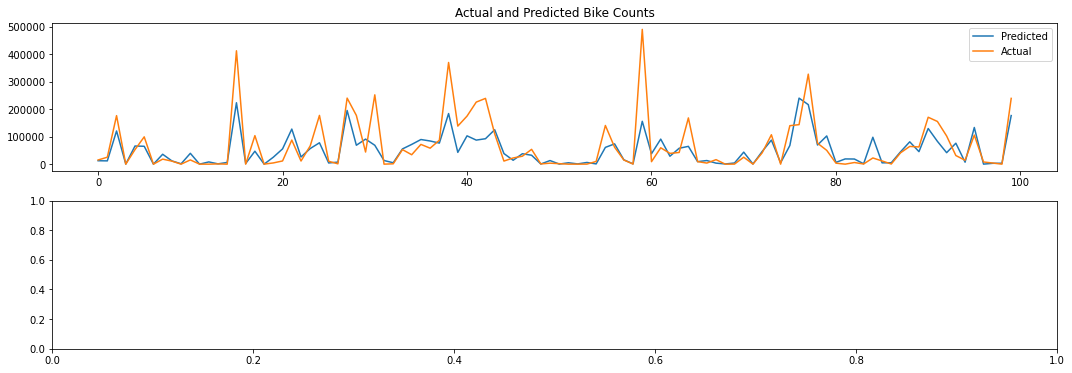

In [41]:
# Fitting Linear Regression Model
lr = LinearRegression()
analyse_model(lr, X_train, X_test, Y_train, Y_test)

[18:59:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[18:59:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[18:59:44] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[18:59:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[18:59:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:59:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:00] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:00:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:00:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:00:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:00:44] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:00:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:00:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:00] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:01:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:01:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:02:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:02:20] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:02:27] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:28] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:29] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:02:35] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:02:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:02:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:51] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:03:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:03:14] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:03:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:03:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:03:53] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:04:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:04:31] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:04:54] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:54] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:05:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:05:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:05:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:05:31] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:31] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:32] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:05:38] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:39] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:39] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:05:49] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:06:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:06:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:06:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:06:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:06:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:00] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:07:19] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[19:07:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:38] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

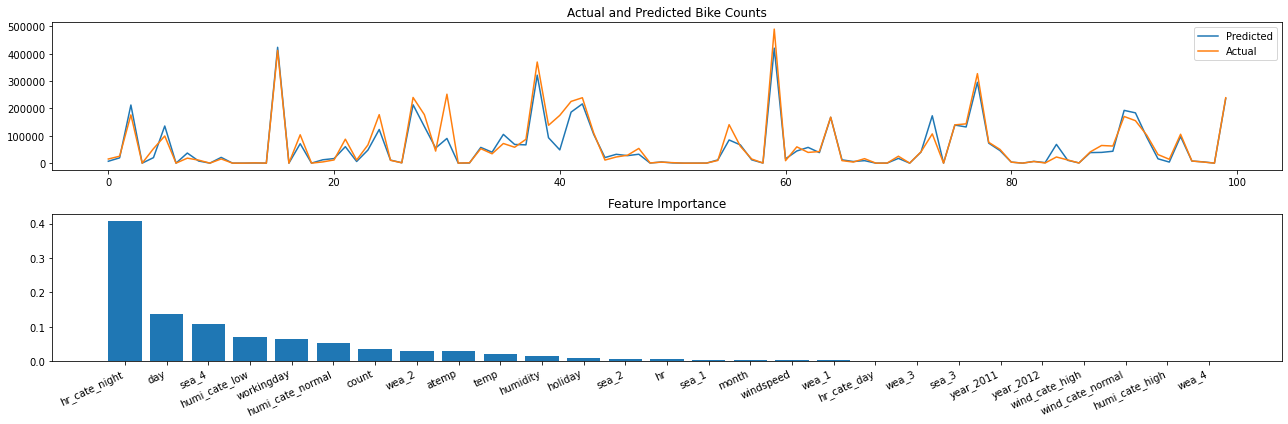

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=8, min_child_weight=1,
             min_samples_leaf=40, min_samples_split=50, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=3, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1,
             tree_method='exact', ...)

In [44]:
# Providing the range of values for hyperparameters such as Number of trees:
n_estimators = [50,100,150]

# Maximum depth of trees:
max_depth = [6,8,10]

# Minimum number of samples required to split a node:
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node:
min_samples_leaf = [40,50]

# Learning rate:
eta = [0.05,0.08,0.1]

# Regressor
regressor = XGBRegressor(silent=True, random_state=3)

# HYperparameter Grid
grid = {'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'min_samples_split' : min_samples_split,
        'min_samples_leaf' : min_samples_leaf,
        'eta' : eta}

# GridSearch to find the best parameters
xgb = GridSearchCV(regressor, param_grid = grid, scoring = 'neg_mean_squared_error', cv=5)
xgb.fit(X_train, Y_train)

# Analysing the model with best set of parametes
analyse_model(xgb.best_estimator_, X_train, X_test, Y_train, Y_test) 

MSE : 1637598410.2253878
RMSE : 40467.25108313373
MAE : 20783.73950714847
Train R2 : 0.818501773695526
Test R2 : 0.8059976568297351
Adjusted R2 :  0.8043576871160228


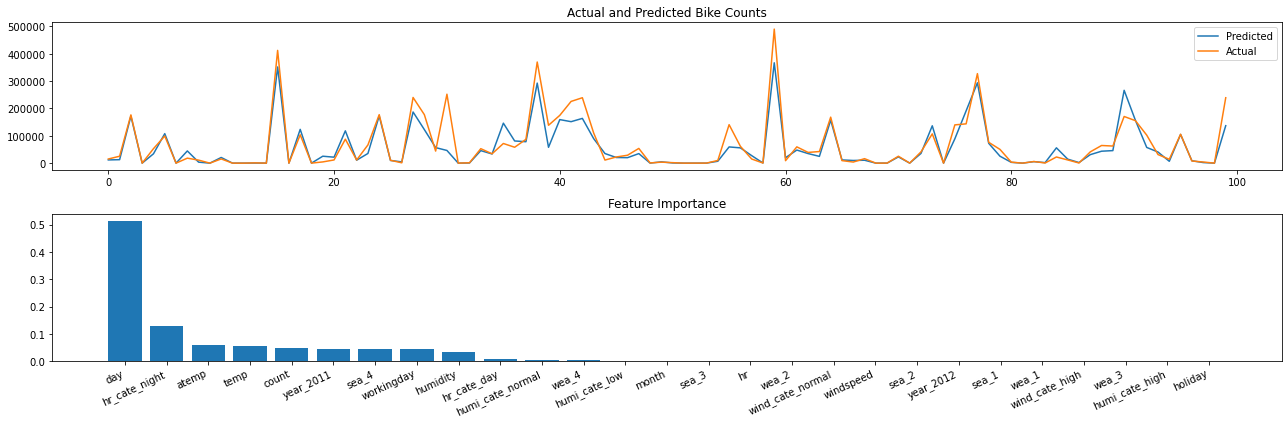

RandomForestRegressor(max_depth=10, min_samples_leaf=40, min_samples_split=50,
                      n_estimators=150, random_state=2)

In [47]:
# Regressor
regressor = RandomForestRegressor(random_state=2)

# HYperparameter Grid
grid = {'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'min_samples_split' : min_samples_split,
        'min_samples_leaf' : min_samples_leaf}

# GridSearch to find the best parameters
rf = GridSearchCV(regressor, param_grid = grid, scoring = 'neg_mean_squared_error', cv=5)
rf.fit(X_train, Y_train)

# Analysing the model with best set of parametes
analyse_model(rf.best_estimator_, X_train, X_test, Y_train, Y_test)

MSE : 760963910.9646767
RMSE : 27585.57432725802
MAE : 13163.587066243832
Train R2 : 0.9607100904341709
Test R2 : 0.9098504365457722
Adjusted R2 :  0.909088370730724


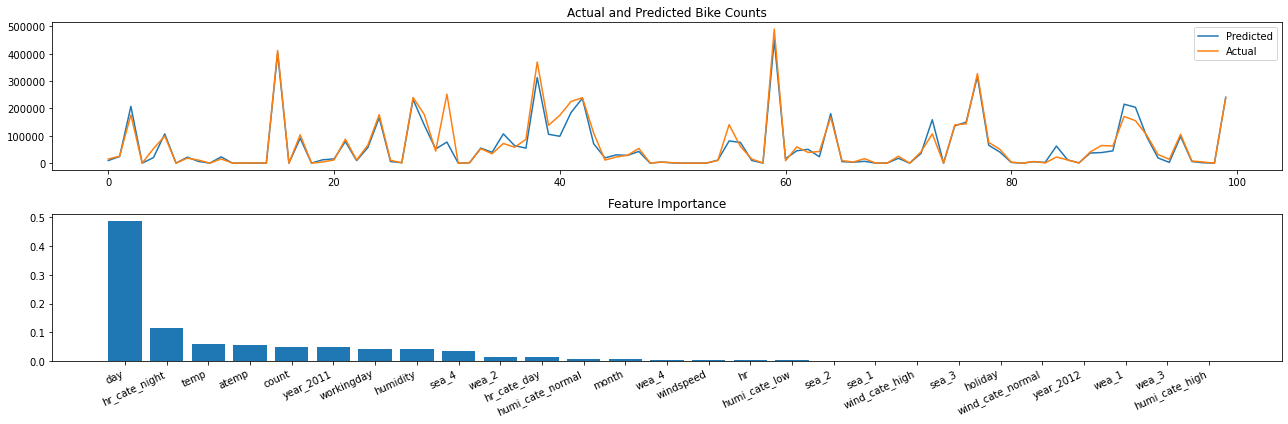

GradientBoostingRegressor(max_depth=10, min_samples_leaf=40,
                          min_samples_split=50, n_estimators=150,
                          random_state=4)

In [49]:
# Regressor
regressor = GradientBoostingRegressor(random_state=4)

# HYperparameter Grid
grid = {'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'min_samples_split' : min_samples_split,
        'min_samples_leaf' : min_samples_leaf}

# GridSearch to find the best parameters
gbr = GridSearchCV(regressor, param_grid = grid, scoring = 'neg_mean_squared_error', cv=5)
gbr.fit(X_train, Y_train)

# Analysing the model with best set of parametes
analyse_model(gbr.best_estimator_, X_train, X_test, Y_train, Y_test)

MSE : 1913481550.061737
RMSE : 43743.360068263355
MAE : 22362.633404484608
Train R2 : 0.8128350039441503
Test R2 : 0.7733144451001541
Adjusted R2 :  0.7713981927575443


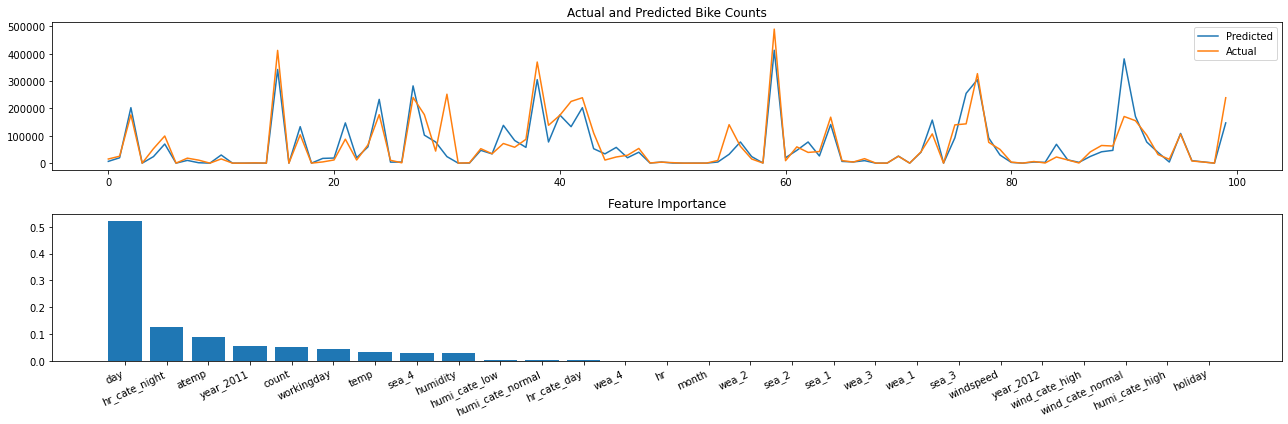

DecisionTreeRegressor(max_depth=10, min_samples_leaf=40, min_samples_split=50,
                      random_state=1)

In [50]:
# Regressor
regressor = DecisionTreeRegressor(random_state=1)

# HYperparameter Grid
grid = {'max_depth' : max_depth,
        'min_samples_split' : min_samples_split,
        'min_samples_leaf' : min_samples_leaf}

# GridSearch to find the best parameters
dt = GridSearchCV(regressor, param_grid = grid, scoring = 'neg_mean_squared_error', cv=5)
dt.fit(X_train, Y_train)

# Analysing the model with best set of parametes
analyse_model(dt.best_estimator_, X_train, X_test, Y_train, Y_test)

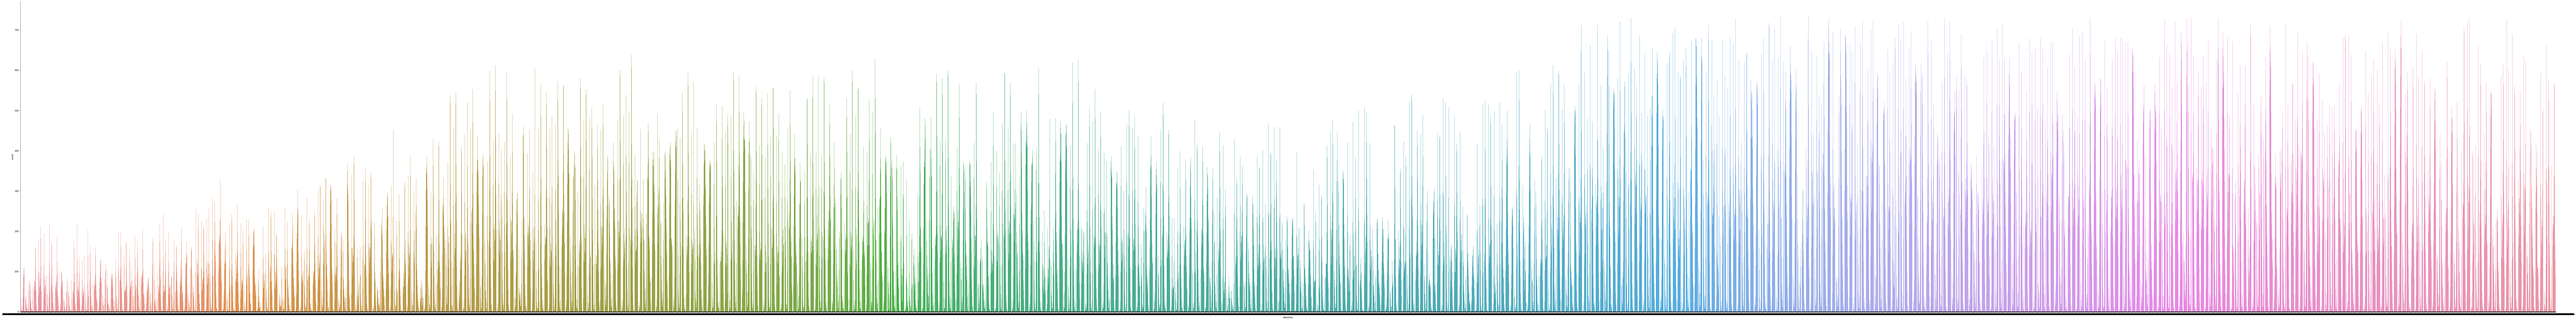

In [54]:
sns.factorplot(x="datetime",y="count",data=train,kind='bar',size=20,aspect=8)


ValueError: could not convert string to float: 'night'

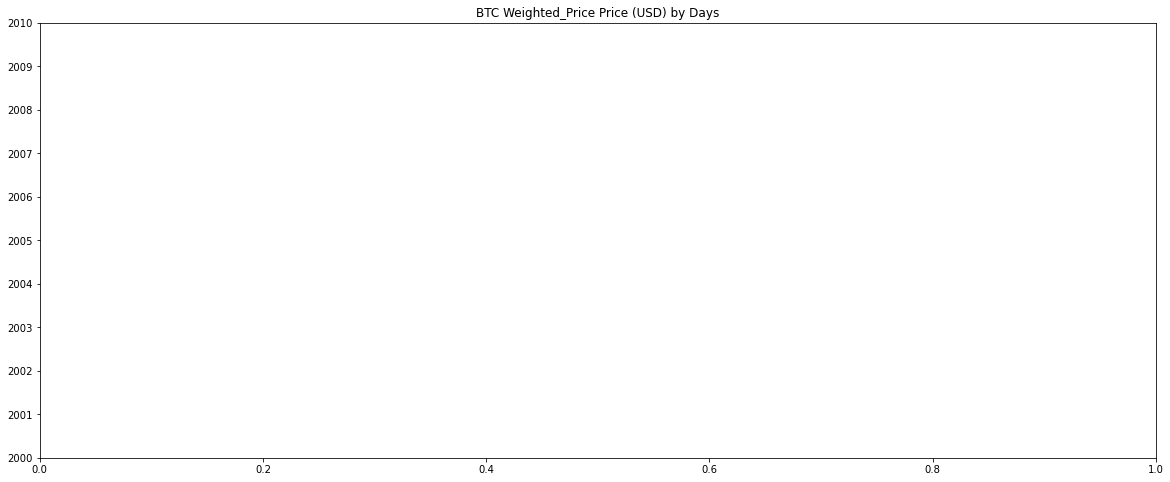

In [55]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Days')
plt.plot(train, '-', label='By Days')

Text(0.5, 1.0, ' Average Rented Bike Count vs Date plot')

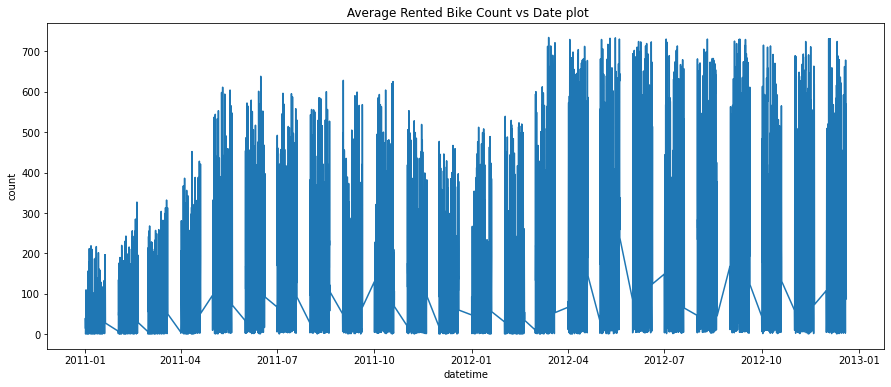

In [58]:
import seaborn as sbn

plt.figure(figsize = (15,6))
grouped = pd.DataFrame(round(train.groupby('datetime')['count'].mean())).rename(columns = {'Rented Bike Count':'Avg Bike Count'})
sbn.lineplot(x = grouped.index, y = grouped['count'])
plt.title(' Average Rented Bike Count vs Date plot')

In [59]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hr,hr_categori,humi_categori,wind_categori
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,NaN,normal,normal
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,NaN,normal,normal
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,NaN,normal,normal
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,NaN,normal,normal
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,NaN,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,rush,normal,high
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,night,normal,high
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,night,normal,high
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,night,normal,normal


In [60]:
X_train

,holiday,workingday,temp,atemp,humidity,windspeed,month,day,hr,wea_1,...,year_2011,year_2012,wind_cate_high,wind_cate_normal,humi_cate_high,humi_cate_low,humi_cate_normal,hr_cate_day,hr_cate_night,hr_cate_rush
4519,0,1,16.40,20.455,66,11.0014,11,1,9,1,...,1,0,0,1,0,0,1,0,0,1
770,0,1,11.48,13.635,24,16.9979,2,15,12,1,...,1,0,1,0,0,0,1,1,0,0
7375,0,0,25.42,30.305,61,0.0000,5,6,16,0,...,0,1,0,1,0,0,1,0,0,0
628,0,1,4.92,6.820,39,11.0014,2,9,9,1,...,1,0,0,1,0,0,1,0,0,1
2177,0,1,25.42,30.305,69,30.0026,5,17,15,1,...,1,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,0,0,16.40,20.455,58,7.0015,11,10,11,1,...,0,1,0,1,0,0,1,0,0,0
6374,0,1,14.76,17.425,87,12.9980,3,2,20,0,...,0,1,0,1,1,0,0,0,1,0
1628,0,1,18.04,21.970,62,26.0027,4,13,18,1,...,1,0,1,0,0,0,1,0,0,1
1479,0,1,18.86,22.725,55,0.0000,4,7,12,0,...,1,0,0,1,0,0,1,1,0,0


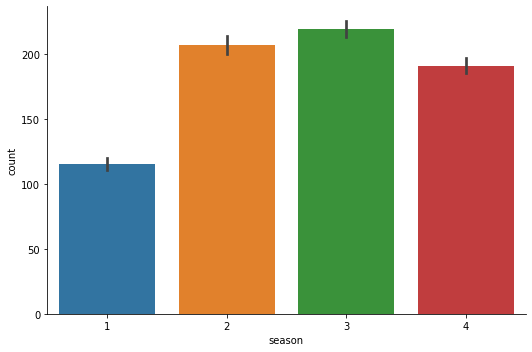

In [61]:
sns.factorplot(x="season",y="count",data=train,kind='bar',size=5,aspect=1.5)
